# Kalman Filter

In [9]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

In [5]:
def run_kalman_filter_and_predict(batch_positions):
    """
    Applies Kalman Filter to the first 5 timesteps to predict the next 10 timesteps.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3)
                         containing the 3D positions.
                         
    Returns:
        A numpy array of shape (batch_size, 15, 6) containing the
        predicted states (position and velocity) for each timestep in each batch.
    """
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 6))
    
    for i in range(batch_size):
        # Time step
        dt = 1.0
        
        # Create a KalmanFilter instance
        kf = KalmanFilter(dim_x=6, dim_z=3)
        
        # State Transition matrix A
        kf.F = np.array([[1, 0, 0, dt, 0, 0],
                         [0, 1, 0, 0, dt, 0],
                         [0, 0, 1, 0, 0, dt],
                         [0, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 0, 1]])
        
        # Measurement matrix H
        kf.H = np.array([[1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0, 0]])
        
        # Initial state covariance
        kf.P *= 10
        
        # Process noise covariance
        kf.Q = np.eye(6) * 0.1
        
        # Measurement noise covariance
        kf.R = np.eye(3) * 1.0
        
        # Initial state (starting with the first position and zero velocity)
        initial_position = batch_positions[i, 0]
        kf.x = np.array([initial_position[0], initial_position[1], initial_position[2], 0, 0, 0])
        
        # Running the Kalman Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            kf.predict()
            kf.update(z)
            predictions[i, t] = kf.x
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            kf.predict()
            predictions[i, t] = kf.x
    
    return predictions

In [10]:
def plot_predictions(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
import tensorflow as tf 
loaded = tf.data.experimental.load(
    "test_dataset"
)
def tf_dataset_to_numpy(tf_dataset):
    numpy_data = []
    for batch in tf_dataset.as_numpy_iterator():
        if batch[0].shape[0]==32:
            numpy_data.append(batch[0])
    return np.asarray(numpy_data)

# Convert the TensorFlow dataset to a numpy array
batch_positions = tf_dataset_to_numpy(loaded)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468


In [24]:
batch_positions.shape

(552, 32, 15, 3)

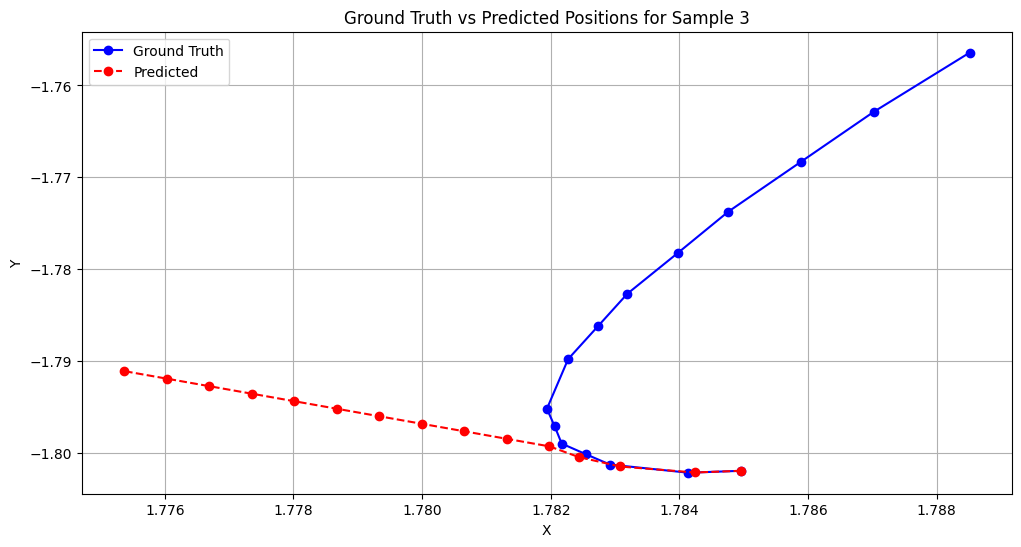

In [39]:
index = 7
predictions = run_kalman_filter_and_predict(batch_positions[0][index:])
plot_predictions(batch_positions[0][index:], predictions, sample_index=3)

# Particle Filter

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform, normal

In [11]:
class ParticleFilter:
    def __init__(self, num_particles, state_dim, measurement_dim):
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, state_dim))
        self.weights = np.ones(num_particles) / num_particles
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.dt = 1.0
        self.process_noise = 1.0  # Process noise standard deviation
        self.measurement_noise = 0.5  # Measurement noise standard deviation

    def create_uniform_particles(self, x_range, y_range, z_range, vx_range, vy_range, vz_range):
        self.particles[:, 0] = uniform(x_range[0], x_range[1], size=self.num_particles)
        self.particles[:, 1] = uniform(y_range[0], y_range[1], size=self.num_particles)
        self.particles[:, 2] = uniform(z_range[0], z_range[1], size=self.num_particles)
        self.particles[:, 3] = uniform(vx_range[0], vx_range[1], size=self.num_particles)
        self.particles[:, 4] = uniform(vy_range[0], vy_range[1], size=self.num_particles)
        self.particles[:, 5] = uniform(vz_range[0], vz_range[1], size=self.num_particles)

    def predict(self):
        self.particles[:, 0] += self.particles[:, 3] * self.dt + normal(0, self.process_noise, size=self.num_particles)
        self.particles[:, 1] += self.particles[:, 4] * self.dt + normal(0, self.process_noise, size=self.num_particles)
        self.particles[:, 2] += self.particles[:, 5] * self.dt + normal(0, self.process_noise, size=self.num_particles)

    def update(self, z):
        diff = self.particles[:, :3] - z
        dist = np.linalg.norm(diff, axis=1)
        self.weights *= np.exp(-0.5 * (dist**2) / self.measurement_noise**2)
        self.weights += 1.e-300  # Avoid division by zero
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = systematic_resample(self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

def run_particle_filter_and_predict(batch_positions, num_particles=1000):
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 6))
    
    for i in range(batch_size):
        pf = ParticleFilter(num_particles, state_dim=6, measurement_dim=3)
        pf.create_uniform_particles((0, 10), (0, 10), (0, 10), (-1, 1), (-1, 1), (-1, 1))

        # Running the Particle Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            pf.predict()
            pf.update(z)
            pf.resample()
            predictions[i, t] = pf.estimate()
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            pf.predict()
            predictions[i, t] = pf.estimate()
    
    return predictions

def plot_predictions(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
import tensorflow as tf 
loaded = tf.data.experimental.load(
    "test_dataset"
)
def tf_dataset_to_numpy(tf_dataset):
    numpy_data = []
    for batch in tf_dataset.as_numpy_iterator():
        if batch[0].shape[0]==32:
            numpy_data.append(batch[0])
    return np.asarray(numpy_data)

# Convert the TensorFlow dataset to a numpy array
batch_positions = tf_dataset_to_numpy(loaded)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 17404134898602437468


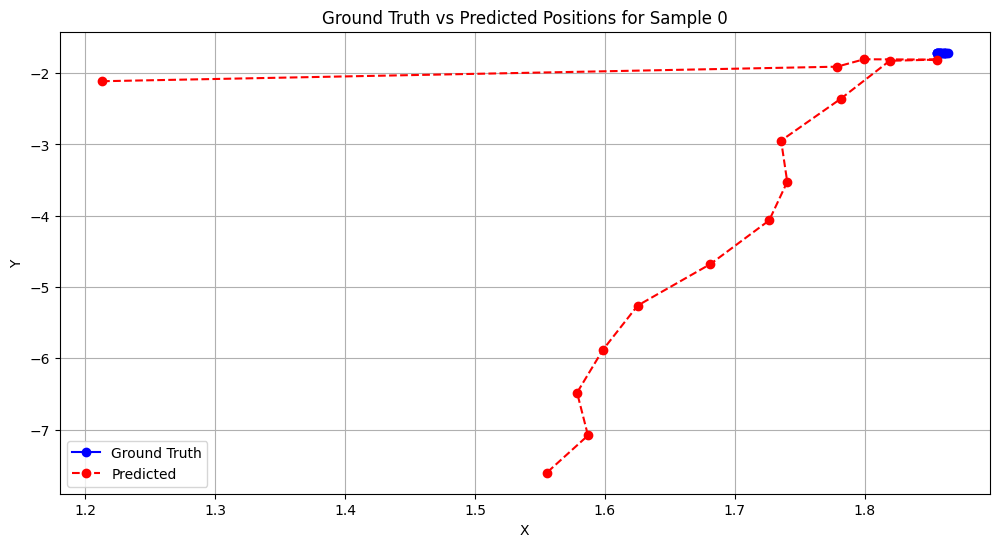

In [26]:
# Example usage
#batch_positions = np.array([
    #[[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5], [6, 6, 6], [7, 7, 7], [8, 8, 8], [9, 9, 9], [10, 10, 10], [11, 11, 11], [12, 12, 12], [13, 13, 13], [14, 14, 14], [15, 15, 15]],
    #[[1, 0, 0], [2, 0, 0], [3, 0, 0], [4, 0, 0], [5, 0, 0], [6, 0, 0], [7, 0, 0], [8, 0, 0], [9, 0, 0], [10, 0, 0], [11, 0, 0], [12, 0, 0], [13, 0, 0], [14, 0, 0], [15, 0, 0]]
#])

index = 7

predictions = run_particle_filter_and_predict(batch_positions[0][index:]) # with example only batch_positions
plot_predictions(batch_positions[0][index:], predictions, sample_index=0)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.monte_carlo import stratified_resample
from numpy.random import uniform, normal

class AdaptiveParticleFilter:
    def __init__(self, num_particles, state_dim, measurement_dim):
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, state_dim))
        self.weights = np.ones(num_particles) / num_particles
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.dt = 1.0
        self.process_noise = 1.0  # Initial process noise standard deviation
        self.measurement_noise = 0.5  # Initial measurement noise standard deviation

    def create_uniform_particles(self, x_range, y_range, z_range, vx_range, vy_range, vz_range):
        self.particles[:, 0] = uniform(x_range[0], x_range[1], size=self.num_particles)
        self.particles[:, 1] = uniform(y_range[0], y_range[1], size=self.num_particles)
        self.particles[:, 2] = uniform(z_range[0], z_range[1], size=self.num_particles)
        self.particles[:, 3] = uniform(vx_range[0], vx_range[1], size=self.num_particles)
        self.particles[:, 4] = uniform(vy_range[0], vy_range[1], size=self.num_particles)
        self.particles[:, 5] = uniform(vz_range[0], vz_range[1], size=self.num_particles)

    def predict(self):
        self.particles[:, 0] += self.particles[:, 3] * self.dt + normal(0, self.process_noise, size=self.num_particles)
        self.particles[:, 1] += self.particles[:, 4] * self.dt + normal(0, self.process_noise, size=self.num_particles)
        self.particles[:, 2] += self.particles[:, 5] * self.dt + normal(0, self.process_noise, size=self.num_particles)

    def update(self, z):
        diff = self.particles[:, :3] - z
        dist = np.linalg.norm(diff, axis=1)
        self.weights *= np.exp(-0.5 * (dist**2) / self.measurement_noise**2)
        self.weights += 1.e-300  # Avoid division by zero
        self.weights /= np.sum(self.weights)

        # Adaptive noise adjustment based on variance of weights
        self.process_noise = max(1.0, np.std(self.particles[:, :3]) * 0.1)
        self.measurement_noise = max(0.5, np.std(self.particles[:, :3]) * 0.1)

    def resample(self):
        indices = stratified_resample(self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

def run_particle_filter_and_predict2(batch_positions, num_particles=1000):
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 6))
    
    for i in range(batch_size):
        pf = AdaptiveParticleFilter(num_particles, state_dim=6, measurement_dim=3)
        pf.create_uniform_particles((0, 10), (0, 10), (0, 10), (-1, 1), (-1, 1), (-1, 1))

        # Running the Particle Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            pf.predict()
            pf.update(z)
            pf.resample()
            predictions[i, t] = pf.estimate()
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            pf.predict()
            predictions[i, t] = pf.estimate()
    
    return predictions

def plot_predictions2(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()


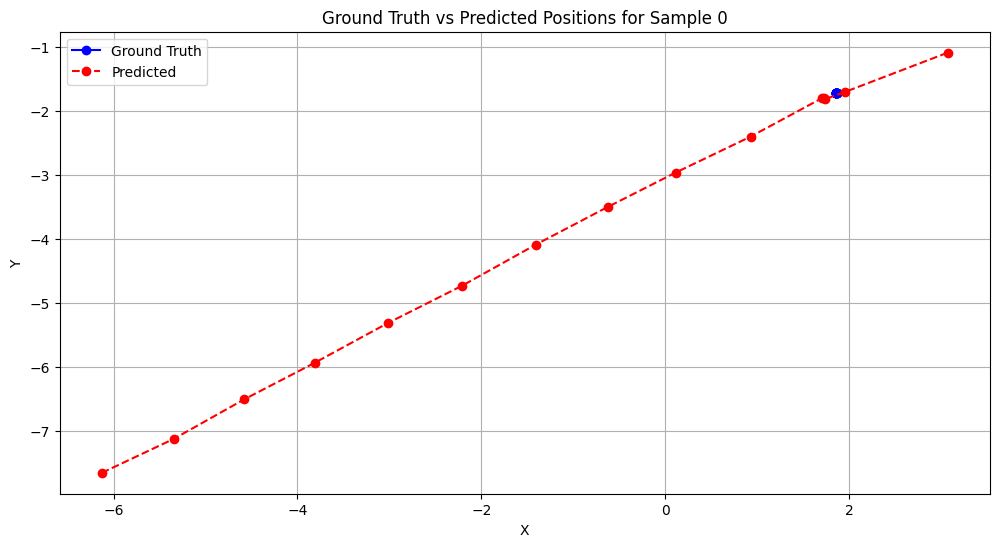

In [29]:
index = 7

predictions = run_particle_filter_and_predict2(batch_positions[0][index:]) # with example only batch_positions
plot_predictions2(batch_positions[0][index:], predictions, sample_index=0)

# Unscented Particle Filter

In [31]:
from filterpy.monte_carlo import stratified_resample
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

class UnscentedParticleFilter:
    def __init__(self, num_particles, state_dim, measurement_dim):
        self.num_particles = num_particles
        self.particles = np.zeros((num_particles, state_dim))
        self.weights = np.ones(num_particles) / num_particles
        self.state_dim = state_dim
        self.measurement_dim = measurement_dim
        self.dt = 1.0
        self.process_noise = 1.0  # Process noise standard deviation
        self.measurement_noise = 0.5  # Measurement noise standard deviation

    def create_uniform_particles(self, x_range, y_range, z_range, vx_range, vy_range, vz_range):
        self.particles[:, 0] = np.random.uniform(x_range[0], x_range[1], size=self.num_particles)
        self.particles[:, 1] = np.random.uniform(y_range[0], y_range[1], size=self.num_particles)
        self.particles[:, 2] = np.random.uniform(z_range[0], z_range[1], size=self.num_particles)
        self.particles[:, 3] = np.random.uniform(vx_range[0], vx_range[1], size=self.num_particles)
        self.particles[:, 4] = np.random.uniform(vy_range[0], vy_range[1], size=self.num_particles)
        self.particles[:, 5] = np.random.uniform(vz_range[0], vz_range[1], size=self.num_particles)

    def predict(self):
        for i in range(self.num_particles):
            sigma_points = MerweScaledSigmaPoints(n=self.state_dim, alpha=0.1, beta=2.0, kappa=0.0)
            ukf = UnscentedKalmanFilter(dim_x=self.state_dim, dim_z=self.measurement_dim, dt=self.dt,
                                        fx=self.fx, hx=self.hx, points=sigma_points)
            ukf.x = self.particles[i]
            ukf.P = np.eye(self.state_dim) * self.process_noise
            ukf.predict()
            self.particles[i] = ukf.x

    def fx(self, x, dt):
        # State transition function
        F = np.eye(self.state_dim)
        F[0, 3] = dt
        F[1, 4] = dt
        F[2, 5] = dt
        return np.dot(F, x)

    def hx(self, x):
        # Measurement function
        return x[:3]

    def update(self, z):
        for i in range(self.num_particles):
            sigma_points = MerweScaledSigmaPoints(n=self.state_dim, alpha=0.1, beta=2.0, kappa=0.0)
            ukf = UnscentedKalmanFilter(dim_x=self.state_dim, dim_z=self.measurement_dim, dt=self.dt,
                                        fx=self.fx, hx=self.hx, points=sigma_points)
            ukf.x = self.particles[i]
            ukf.P = np.eye(self.state_dim) * self.process_noise
            ukf.R = np.eye(self.measurement_dim) * self.measurement_noise
            ukf.update(z)
            self.particles[i] = ukf.x

        self.weights.fill(1.0 / self.num_particles)

    def resample(self):
        indices = stratified_resample(self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

def run_unscented_particle_filter_and_predict(batch_positions, num_particles=1000):
    batch_size, timesteps, _ = batch_positions.shape
    assert timesteps == 15, "The input should have 15 timesteps per sequence."
    
    predictions = np.zeros((batch_size, 15, 6))
    
    for i in range(batch_size):
        upf = UnscentedParticleFilter(num_particles, state_dim=6, measurement_dim=3)
        upf.create_uniform_particles((0, 10), (0, 10), (0, 10), (-1, 1), (-1, 1), (-1, 1))

        # Running the Particle Filter for the first 5 timesteps
        for t in range(5):
            z = batch_positions[i, t]
            upf.predict()
            upf.update(z)
            upf.resample()
            predictions[i, t] = upf.estimate()
        
        # Predicting the next 10 timesteps without updating
        for t in range(5, 15):
            upf.predict()
            predictions[i, t] = upf.estimate()
    
    return predictions

def plot_predictions3(batch_positions, predictions, sample_index=0):
    """
    Plots the ground truth vs predicted positions.
    
    Args:
        batch_positions: A numpy array of shape (batch_size, 15, 3) containing the ground truth positions.
        predictions: A numpy array of shape (batch_size, 15, 6) containing the predicted states.
        sample_index: The index of the sample to plot (default is 0).
    """
    ground_truth = batch_positions[sample_index]
    predicted_positions = predictions[sample_index, :, :3]  # Get only the position components
    
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], 'bo-', label='Ground Truth')
    plt.plot(predicted_positions[:, 0], predicted_positions[:, 1], 'ro--', label='Predicted')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Ground Truth vs Predicted Positions for Sample {sample_index}')
    plt.legend()
    plt.grid(True)
    plt.show()

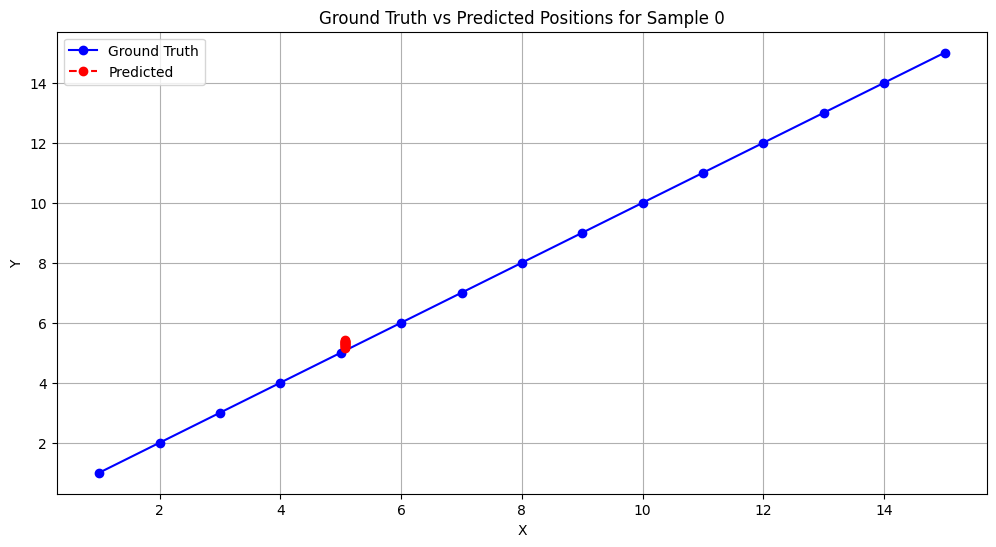

In [34]:
# Example usage
batch_positions2 = np.array([
    [[1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5], [6, 6, 6], [7, 7, 7], [8, 8, 8], [9, 9, 9], [10, 10, 10], [11, 11, 11], [12, 12, 12], [13, 13, 13], [14, 14, 14], [15, 15, 15]],
    [[1, 0, 0], [2, 0, 0], [3, 0, 0], [4, 0, 0], [5, 0, 0], [6, 0, 0], [7, 0, 0], [8, 0, 0], [9, 0, 0], [10, 0, 0], [11, 0, 0], [12, 0, 0], [13, 0, 0], [14, 0, 0], [15, 0, 0]]
])

predictions = run_unscented_particle_filter_and_predict(batch_positions2)
plot_predictions3(batch_positions2, predictions, sample_index=0)